<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D1_RealNeurons/W3D1_Tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 1, Tutorial 4
# Real Neurons: Spike-timing dependent plasticity (STDP)

## Objectives

In this tutorial, we will focus on building a model of a synapse in which its synaptic strength changes as a function of the relative timing (i.e., time difference) between the spikes of the pre- and post-synaptic neurons, respectively. This change in the synaptic weight is known as **spike-timing dependent plasticity (STDP)**.

Our goals for this tutorial are to:

- build a model of synapse that show STDP.

- study how correlations in input spike trains influence the distribution of synapstic weights.

Towards these goals, we will model the presynaptic input as Poisson type spike trains. The postsynaptic neuron will be modeled as an LIF neuron (see Tutorial 1).

Throughout this tutorial, we assume that a single postsynaptic neuron is drived by $N$ presynaptic neurons. That is, there are $N$ synapses and we will study how their weights depend on the statistics or the input spike trains and their timing with respect to the spikes of the postsynaptic neuron.


# Setup

In [1]:
# Imports
import matplotlib.pyplot as plt    # import matplotlib
import numpy as np                 # import numpy
import time                        # import time
import ipywidgets as widgets       # interactive display
from scipy.stats import pearsonr   # import pearson correlation

In [2]:
#@title Figure settings
%matplotlib inline
fig_w, fig_h = (8, 6)
my_fontsize = 18
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': (fig_w, fig_h),
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)
my_layout = widgets.Layout()

In [3]:
#@title Helper functions

# Poisson type spike trains generator
def Poisson_generator(pars, rate, n, myseed=False):
    """Generates poisson trains
    
    Args:
      pars            : parameter dictionary
      rate            : noise amplitute [Hz]
      n               : number of Poisson trains
      myseed          : random seed. int or boolean
      
    Returns:
      pre_spike_train : spike train matrix, ith row represents whether
                        there is a spike in ith spike train over time
                        (1 if spike, 0 otherwise)
      
    """
    
    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    
    # set random seed
    if myseed:
        np.random.seed(seed=myseed) 
    else:
        np.random.seed()
    
    # generate uniformly distributed random variables
    u_rand = np.random.rand(n, Lt)
    
    # generate Poisson train
    poisson_train = 1. * (u_rand<rate*dt/1000.)
    
    return poisson_train

#print(help(Poisson_generator))

# the function plot the raster of the Poisson spike train
def my_raster_plot(range_t, spike_train, n):
    """Generates poisson trains
    
    Args:
      range_t     : time sequence 
      spike_train : binary spike trains, with shape (N, Lt)
      n           : number of Poisson trains plot
    
    Returns:
      Raster_plot of the spike train
    """

    # Find the number of all the spike trains
    N = spike_train.shape[0]

    # n should be smaller than N:
    if n > N:
       print('The number n exceeds the size of spike trains')
       print('The number n is set to be the size of spike trains')
       n = N

    # Raster plot
    i = 0
    while i<= n:
        if spike_train[i, :].sum()>0.:
          t_sp = range_t[spike_train[i, :]>0.5] #spike times 
          plt.plot(t_sp, i*np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
        i += 1
    plt.xlim([range_t[0], range_t[-1]])
    plt.ylim([-0.5, n+0.5])    
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')

def my_example_P():
    """
    only for the P exercise cell
    
    Args:

    Returns:
      plot

    """

    spT = pre_spike_train_ex[pre_spike_train_ex.sum(axis=1)>0.,:]
    plt.figure(figsize=(7, 6))
    plt.subplot(211)
    color_set = ['r', 'b', 'k', 'orange', 'c']
    for i in range(spT.shape[0]):
        t_sp = pars['range_t'][spT[i, :]>0.5] #spike times 
        plt.plot(t_sp, i*np.ones(len(t_sp)), '|', color=color_set[i], 
                ms=10, markeredgewidth=2)
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')
    plt.xlim(0, 200)

    plt.subplot(212)
    for k in range(5):
      plt.plot(pars['range_t'], P[k,:], color=color_set[k], lw=1.5)
    plt.xlabel('Time (s)')
    plt.ylabel('P(t)')
    plt.xlim(0, 200)

    plt.tight_layout()

## Spike-timing dependent plasticity (STDP)

Video available at https://youtube.com/watch?v=BZx1EHX0pmA


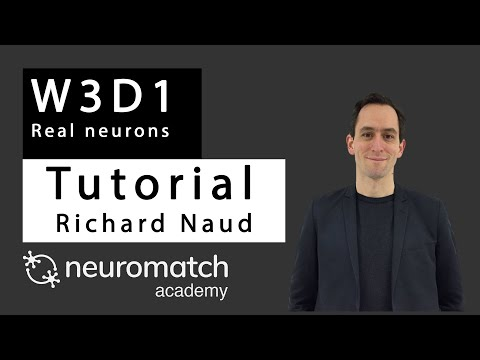

In [4]:
#@title Video of STDP
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='BZx1EHX0pmA', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Model of STDP

The phenomenology of STDP is generally described as a biphasic exponentially decaying function. That is, the instantaneous change in weights is given by:

\begin{eqnarray}
& \Delta W = A_+ e^{ (t_{pre}-t_{post})/\tau_+}  \hspace{10mm} \text{if} \hspace{5mm}  t_{post} > t_{pre}\\
& \Delta W =  -A_- e^{- (t_{pre}-t_{post})/\tau_-}   \hspace{7mm} \text{if} \hspace{5mm} t_{post} < t_{pre}
\end{eqnarray}

where $\Delta W$ denotes the change in the synaptic weight, $A_+$ and $A_-$ determine the maxmimum amount of synaptic modification (which occurs when the timing difference between pre- and post-synaptic spikes is close to zero), $\tau_+$ and $\tau_-$ determine the ranges of pre-to-postsynaptic interspike intervals over which synaptic strengthening or weakening occurs. Thus, $\Delta W > 0 $ means that post-synaptic neuron spikes after the pre-synaptic neuron.

This model captures the phenomena that repeated occurrences of presynaptic spikes within a few milliseconds **before** postsynaptic action potentials lead to long-term potentiation (LTP) of the synapse, whereas repeated occurrences of presynaptic spikes **after** the postsynaptic ones lead to long-term depression (LTD) of the same synapse.

The latency between pre- and postsynaptic spike ($\Delta t$) is defined as:

\begin{eqnarray}
\Delta t = t_{\rm pre} - t_{\rm post}
\end{eqnarray}

where $t_{\rm pre}$ and $t_{\rm post}$ are the timings of the pre- and postsynaptic spikes, respectively.


Execute the following code to set the STDP parameters and plot the STDP function. For simplicity, we assume that $\tau_{+} = \tau_{-} = \tau_{\rm stdp}$.

In [5]:
#@title Default parameters dictionary
def default_pars_STDP( **kwargs):
    pars = {}
    
    ### typical neuron parameters ###
    pars['V_th']    = -55. # spike threshold [mV]
    pars['V_reset'] = -75. # reset potential [mV]
    pars['tau_m']   = 10.  # membrane time constant [ms]
    pars['V_init']  = -65. # initial potential [mV]
    pars['V_L']     = -75. # leak reversal potential [mV]
    pars['tref']    = 2.   # refractory time (ms)
    
    ### STDP parameters ###
    pars['A_plus']   = 0.008               # magnitude of LTP
    pars['A_minus']  = pars['A_plus']*1.10 # magnitude of LTD
    pars['tau_stdp'] = 20.                 # STDP time constant [ms]

    ### simulation parameters ###
    pars['T'] = 400. # Total duration of simulation [ms]
    pars['dt'] = .1  # Simulation time step [ms]
    
    ### external parameters if any ###
    for k in kwargs:
        pars[k] = kwargs[k]
    
    pars['range_t'] = np.arange(0, pars['T'], pars['dt']) # Vector of discretized time points [ms]
        
    return pars

### Exercise 1: Compute the STDP changes $\Delta W$

Note, as shown above, the expression of $\Delta W$ are different for $t_{post}>t_{pre}$ and $t_{post}<t_{pre}$. In the code, we use the parameter `time_diff` that describes the $t_{pre}-t_{post}$, as given above.

After implementing the code, you can visualize the STDP kernel which describes by how much the synaptic weight will change given a latency between the pre- and postsynaptic spikes. 

In [6]:
# Exercise 1
def Delta_W(pars):
    """
    Plot STDP biphasic exponential decaying function
    
    Args:
      pars       : parameter dictionary
    
    Returns:
      dW         : instantaneous change in weights
    """
    
    # Get parameters
    A_plus, A_minus, tau_stdp = pars['A_plus'], pars['A_minus'], pars['tau_stdp']
    
    #pre_spike time - post_spike time
    time_diff = np.linspace(-5*tau_stdp, 5*tau_stdp, 50)
    
    #STDP change
    dW = np.zeros(len(time_diff))
    #######################################################################
    ## TODO for students: compute dW, then remove the NotImplementedError #
    #######################################################################
    # Note for time_diff<=0, t_post>t_pre, LTP
    # dW =...
    # Note for time_diff>0, t_post<t_pre, LTD
    # dW =...

    raise NotImplementedError("Student excercise: compute the change STDP weight change")

    plt.figure()
    plt.plot([-5*tau_stdp,5*tau_stdp],[0,0],'k',linestyle=':')
    plt.plot([0,0],[-A_minus,A_plus],'k',linestyle=':')

    plt.plot(time_diff[time_diff<=0], dW[time_diff<=0], 'ro')
    plt.plot(time_diff[time_diff>0], dW[time_diff>0], 'bo')

    plt.xlabel(r't$_{\mathrm{pre}}$ - t$_{\mathrm{post}}$ (ms)')
    plt.ylabel(r'$\Delta$W',fontsize=12)
    plt.title('Biphasic STDP',fontsize=12, fontweight='bold')
    plt.show()

# Uncomment these lines after completing the Delta_W function    
# pars = default_pars_STDP()
# Delta_W(pars)  

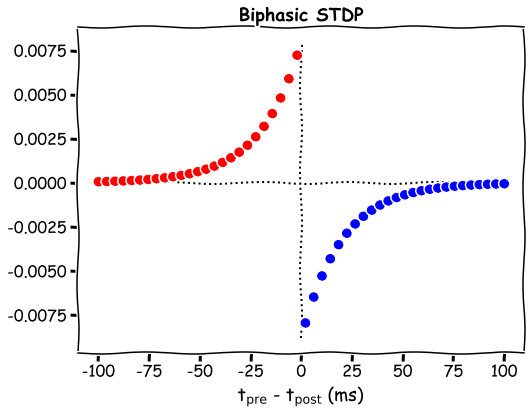

In [7]:
# to_remove solution
def Delta_W(pars):
    """
    Plot STDP biphasic exponential decaying function
    
    Args:
      pars       : parameter dictionary
    
    Returns:
      dW         : instantaneous change in weights
    """
    
    # Get parameters
    A_plus, A_minus, tau_stdp = pars['A_plus'], pars['A_minus'], pars['tau_stdp']
    
    #pre_spike time - post_spike time
    time_diff = np.linspace(-5*tau_stdp, 5*tau_stdp, 50)
    
    #STDP change
    dW = np.zeros(len(time_diff))
    dW[time_diff<=0] = A_plus * np.exp(time_diff[time_diff<=0]/tau_stdp)  #LTP
    dW[time_diff>0] = -A_minus * np.exp(-time_diff[time_diff>0]/tau_stdp) #LTD

    with plt.xkcd():

      plt.figure()
      plt.plot([-5*tau_stdp,5*tau_stdp],[0,0],'k',linestyle=':')
      plt.plot([0,0],[-A_minus,A_plus],'k',linestyle=':')

      plt.plot(time_diff[time_diff<=0], dW[time_diff<=0], 'ro')
      plt.plot(time_diff[time_diff>0], dW[time_diff>0], 'bo')

      plt.xlabel(r't$_{\mathrm{pre}}$ - t$_{\mathrm{post}}$ (ms)')
      plt.title('Biphasic STDP', fontweight='bold')
      plt.show()
    
pars = default_pars_STDP()
Delta_W(pars)

### Keeping track of pre- and postsynaptic spikes
Since a neuron will receive numerous presynaptic spike inputs, in order to implement STDP by taking into account different synapses, we first have to keep track of the pre- and postsynaptic spike times throughout the simulation. 

A convenient way to do this is to define the following equation for each postsynaptic neuron:

\begin{eqnarray}
\tau_{-} \frac{dM}{dt} = -M
\end{eqnarray}

and whenever the postsynaptic neuron spikes, 

\begin{eqnarray}
M(t) = M(t) - A_{-}
\end{eqnarray}

This way $M(t)$ tracks the number of postsynaptic spikes over the timescale $\tau_{-}$. 

Similarly, for each presynaptic neuron we define:

\begin{eqnarray}
\tau_{+} \frac{dP}{dt} = -P
\end{eqnarray}

and whenever there is spike on the presynaptic neuron,

\begin{eqnarray}
P(t) = P(t) + A_{+}
\end{eqnarray}

The variables $M(t)$ and $P(t)$ are very similar to the equations for the synaptic conductances, i.e., $g_{i}(t)$, except that they are used to keep track of pre- and postsynaptic spike times on a much longer timescale. Note that, $M(t)$ is always negative and $P(t)$ is always positive. You can probably already guess that $M$ is used to induce LTD and $P$ to induce LTP because they are updated by $A_{-}$ and $A_{+}$, respectively. 

**Important note:** $P(t)$ depends on the presynaptic spike times. If we know the presynaptic spike times, $P$ can be generated before simulating the postsynaptic neuron and the corresponding STDP weights.

### Visualization of $P$
Here, we will consider a scenario in which there is a single postsynaptic neuron connected to $N$ presynaptic neurons. 

For instance, we have one post-synaptic neuron which receives Poisson type spiking inputs from five pre-synaptic neurons. 

We can simulate $P$ for each one of the presynaptic neurons. 

### Exercise 2: Compute $dP$

Here, yet again, we use the Euler scheme, which have been introduced several times in the previous tutorials.

Similar to the dynamics of the membrane potential in the LIF model, in a time step $dt$, $P(t)$ will decrease by an amount of $\displaystyle{\frac{dt}{\tau_+}P(t)}$. Whereas, if a presynpatic spike arrives, $P(t)$ will instantaneously increase by an amount of $A_+$. Therefore, 

\begin{eqnarray}
dP = -\displaystyle{\frac{dt}{\tau_+}P[t]} + A_+\cdot \text{sp_or_not}[t+dt]
\end{eqnarray}

where the $\text{sp_or_not}$ is a binary variable, i.e., $\text{sp_or_not}=1$ if there is a spike in $dt$, and $\text{sp_or_not}=0$ otherwise.

In [8]:
# Exercise 2
def generate_P(pars, pre_spike_train_ex):
    """
    track of pre-synaptic spikes
    
    Args:
      pars               : parameter dictionary
      pre_spike_train_ex : binary spike train input from 
                           presynaptic excitatory neuron
    
    Returns:
      P                  : LTP ratio
    """
    
    # Get parameters
    A_plus, tau_stdp = pars['A_plus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    n_pre = pre_spike_train_ex.shape[0]
    
    #Initialize
    P = np.zeros(pre_spike_train_ex.shape)
    for n in range(Lt-1):
        #######################################################################
        ## TODO for students: compute dP, then remove the NotImplementedError #
        #######################################################################
        # dP = decay_part + (spike or not) * A_plus
        # Note the pre_spike_train_ex type, it is binary spike train already

        raise NotImplementedError("Student excercise: compute P, the change of presynaptic spike")

        P[:, it+1] = P[:, it] + dP
    
    return P

# Uncomment these lines after completing the generate_P function
# pars = default_pars_STDP(T=200., dt=1.)
# pre_spike_train_ex = Poisson_generator(pars, rate=10, n=5, myseed=202007)
# P = generate_P(pars, pre_spike_train_ex)
# my_example_P()

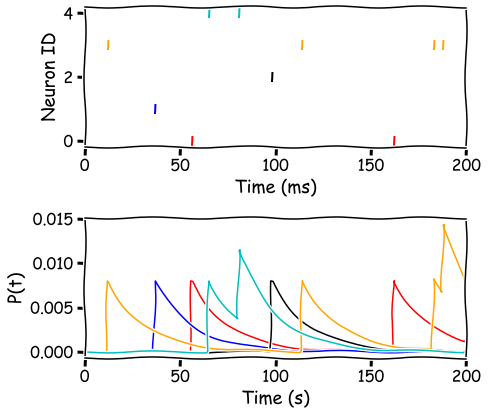

In [9]:
# to_remove solution
def generate_P(pars, pre_spike_train_ex):
    """
    track of pre-synaptic spikes
    
    Args:
      pars               : parameter dictionary
      pre_spike_train_ex : binary spike train input from 
                           presynaptic excitatory neuron
    
    Returns:
      P                  : LTP ratio
    """
    
    # Get parameters
    A_plus, tau_stdp = pars['A_plus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    n_pre = pre_spike_train_ex.shape[0]
    
    #Initialize
    P = np.zeros(pre_spike_train_ex.shape)
    for it in range(Lt-1):
        dP = -(dt/tau_stdp) * P[:, it] + A_plus*pre_spike_train_ex[:, it+1]  # delta increment
        P[:, it+1] = P[:, it] + dP
    
    return P

pars = default_pars_STDP(T=200., dt=1.)
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=5, myseed=202007)
P = generate_P(pars, pre_spike_train_ex)
with plt.xkcd():
  my_example_P()

### Implementation of STDP

Finally, to implement STDP in spiking networks, we will change the value of the peak synaptic conductance based on the pre- and post-synaptic timing, thus using the variables $P(t)$ and $M(t)$. 

Each synapse $i$ has its own peak synaptic conductance ($\bar g_i$) which may vary between $[0, \bar g_{max}]$, and will be modified depending on the pre- and post-synaptic timing. 

* When the $i_{th}$ presynaptic neuron elicits a spike, its corresponding peak conductance is updated according to the following equation:

  \begin{eqnarray}
  \bar g_i = \bar g_i + M(t)\bar g_{max}
  \end{eqnarray}

  Note that, $M(t)$ tracks the time since the last post-synaptic potential and is always negative. Hence, if *the post-synaptic neuron spikes shortly before the pre-synaptic neuron*, the above equation shows that the peak conductance will decrease. 

* When the postsynaptic neuron spikes, the peak conductance of **each** synapse is updated according to:

  \begin{eqnarray}
  \bar g_i = \bar g_i + P_i(t)\bar g_{max}, \forall i
  \end{eqnarray}

  Note that, $P_i(t)$ tracks the time since the last spike of $i_{th}$ pre-synaptic neuron and is always positive.

  Thus, the equation given above shows that if the pre-synaptic neuron spikes before the post-synaptic neuron, its peak conductance will increase.

### LIF neuron connected with synapses that show STDP 
In the following exercise we connect $N$ pre-synaptic neurons to a single post-synaptic neuron. We do not need to simulate the dynamics of each pre-synaptic neuron as we are only concerned about their spike times. So, we will generate $N$ Poisson type spikes. Here, we will assume that all these inputs are excitatory. 

We need to simulate the dynamics of the post-synaptic neuron as we do not know its spike times. We model the post-synaptic neuron as an LIF neuron receiving only excitatory inputs.

\begin{eqnarray}
\tau_m\frac{dV}{dt} = -(V-E_L) - g_E(t) (V(t)-E_E)\,
\end{eqnarray}

where the total excitatory synaptic conductance  $g_{E}(t)$  is given by:

\begin{eqnarray}
g_E(t) = \sum_{i=1}^{N} g_i(t) \,
\end{eqnarray}

While simulating STDP it is important to make sure that $\bar g_i$ never goes outside of its bounds. 


In [10]:
#@title LIF with STDP: `run_LIF_cond_STDP(pars, pre_spike_train_ex)`
def run_LIF_cond_STDP(pars, pre_spike_train_ex):
    '''
    conductance-based LIF dynamics
    
    Args:
      pars               : parameter dictionary
      pre_spike_train_ex : spike train input from presynaptic excitatory neuron
    
    Returns:
      rec_spikes         : spike times
      rec_v              : mebrane potential
      gE                 : postsynaptic excitatory conductance
    '''
    
    # Retrieve parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m = pars['tau_m']
    V_init, V_L = pars['V_init'], pars['V_L']
    gE_bar, VE, tau_syn_E = pars['gE_bar'], pars['VE'], pars['tau_syn_E']
    gE_init = pars['gE_init']
    tref = pars['tref']
    A_plus, A_minus, tau_stdp = pars['A_plus'], pars['A_minus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    
    n_pre = pre_spike_train_ex.shape[0]
    P = generate_P(pars, pre_spike_train_ex)
    
    # Initialize
    tr = 0.
    v = np.zeros(Lt)
    v[0] = V_init
    M = np.zeros(Lt)
    gE = np.zeros(Lt)
    gE_bar_update = np.zeros(pre_spike_train_ex.shape)
    gE_bar_update[:, 0] = gE_init  # note: gE_bar is the maximum value
    
    # simulation
    rec_spikes = [] # recording spike times
    for it in range(Lt-1):
        if tr >0:
            v[it] = V_reset
            tr = tr-1
        elif v[it] >= V_th:         #reset voltage and record spike event
            rec_spikes.append(it)
            v[it] = V_reset
            M[it] = M[it] - A_minus
            gE_bar_update[:, it] = gE_bar_update[:, it] + P[:, it]*gE_bar
            id_temp = gE_bar_update[:, it] > gE_bar
            gE_bar_update[id_temp, it] = gE_bar
            tr = tref/dt

        #update the synaptic conductance
        M[it+1] = M[it] - dt / tau_stdp * M[it]
        gE[it+1] = gE[it] - (dt/tau_syn_E)*gE[it] + (gE_bar_update[:, it]*pre_spike_train_ex[:, it]).sum()
        gE_bar_update[:, it+1] = gE_bar_update[:, it] + M[it]*pre_spike_train_ex[:, it]*gE_bar
        id_temp = gE_bar_update[:, it+1] < 0
        gE_bar_update[id_temp, it+1] = 0.
     
        #calculate the increment of the membrane potential
        dv = (-(v[it]-V_L) - gE[it+1]*(v[it]-VE)) * (dt/tau_m)
        
        #update membrane potential
        v[it+1] = v[it] + dv
        
    rec_spikes = np.array(rec_spikes) * dt
        
    return v, rec_spikes, gE, P, M, gE_bar_update

### Evolution of excitatory synaptic conductance
In the following exercise we will simulate a LIF neuron receiving input from $N=300$ presynaptic neurons.

In [11]:
pars = default_pars_STDP(T=200.,  dt=1.) # Simulation duration 200 ms
pars['gE_bar']    = 0.024                # max synaptic conductance
pars['gE_init']   = 0.024                # initial synaptic conductance
pars['VE']        = 0.                   # [mV] Synapse reversal potential
pars['tau_syn_E'] = 5.                   # [ms] EPSP time constant

# generate Poisson type spike trains
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=300, myseed=2020)
# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars, pre_spike_train_ex)

#running the cell below to see the plots of the evolution of synaptic conductance

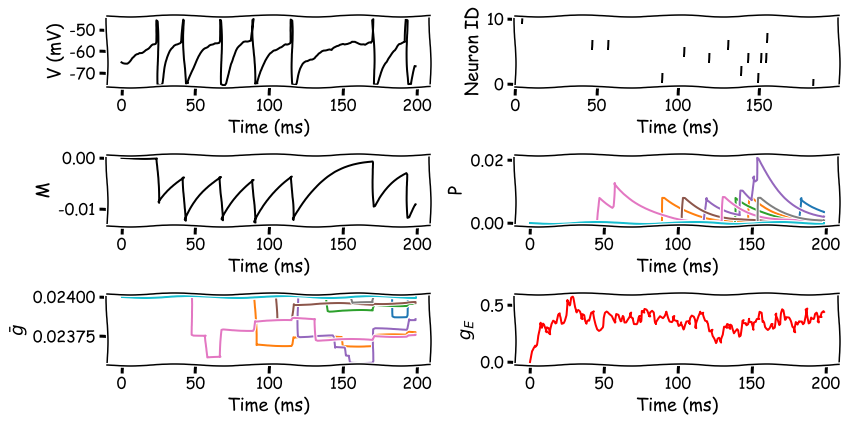

In [12]:
#@title Figures of the evolution of synaptic conductance
with plt.xkcd():
  plt.figure(figsize=(12., 6))
  plt.subplot(3,2,1)
  dt, range_t = pars['dt'], pars['range_t']
  if rec_spikes.size:
      sp_num = (rec_spikes/dt).astype(int)-1
      v[sp_num] += 10   #add artificial spikes
  plt.plot(pars['range_t'], v, 'k')
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)');

  plt.subplot(3,2,2)
  # Plot the sample presynaptic spike trains
  my_raster_plot(pars['range_t'], pre_spike_train_ex, 10)


  plt.subplot(3,2,3)
  plt.plot(pars['range_t'], M, 'k')
  plt.xlabel('Time (ms)')
  plt.ylabel('M')

  plt.subplot(3,2,4)
  for i in range(10):
      plt.plot(pars['range_t'], P[i, :])
  plt.xlabel('Time (ms)')
  plt.ylabel('P')

  plt.subplot(3,2,5)
  for i in range(10):
      plt.plot(pars['range_t'], gE_bar_update[i, :])
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$\bar g$')

  plt.subplot(3,2,6)
  plt.plot(pars['range_t'], gE, 'r')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$g_E$')

  plt.tight_layout()
  plt.show()

### Think!
* In the above, even though all the presynaptic neurons have the same average firing rate, many of the synapses seems to have been weakened? Did you expect that? 

* Total synaptic conductance is fluctuating over time. How do you expect $g_E$ to fluctuate if synapses did not show any STDP like behavior?

* Do synaptic weight ever reach a stationary state when synapses show STDP? 

### Distribution of synaptic weight
From the example given above, we get an idea that some synapses depotentiate, but what is the distribution of the synaptic weights when synapses show STDP? 

In fact, it is possible that even the synaptic weight distribution itself is a time-varying quantitiy. So, we would like to know how the distribution of synaptic weights evolve as a fucntion of time. 

To get a better estimate of the weight distribution and its time evolution, we will increase the pre-synaptic firing rate to $15 Hz$ and simulate the post-synaptic neuron for $120 s$. 

In [13]:
#@title Function `example_LIF_STDP(inputrate=?, Tsim=120000.)`

def example_LIF_STDP(inputrate=15., Tsim=120000.):
    """
    Simulation of a LIF model with STDP synapses

    Args:
      intputrate  :  The rate used for generate presynaptic spike trains
      Tsim        :  Total simulation time

    output:
      Interactive demo, Visualization of synaptic weights
    """

    pars = default_pars_STDP(T=Tsim,  dt=1.)
    pars['gE_bar']    = 0.024
    pars['gE_init']   = 0.014  # initial synaptic conductance
    pars['VE']        = 0.   #[mV]
    pars['tau_syn_E'] = 5.   #[ms]

    starttime = time.perf_counter()
    pre_spike_train_ex = Poisson_generator(pars, rate=inputrate, n=300, myseed=2020) # generate Poisson trains
    v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars, pre_spike_train_ex) # simulate LIF neuron with STDP
    gbar_norm = gE_bar_update/pars['gE_bar'] # calculate the ratio of the synaptic conductance
    endtime = time.perf_counter()
    timecost = (endtime - starttime)/60.

    print ('Total simulation time is %.3f min' % timecost)

    my_layout.width = '620px'
    @widgets.interact(
        sample_time = widgets.FloatSlider(0.5, min=0., max=1., step=0.1, layout=my_layout)
    )

    def my_visual_STDP_distribution(sample_time=0.0):
        
        sample_time = int(sample_time * pars['range_t'].size) - 1
        sample_time = sample_time*(sample_time>0)
        figtemp = plt.figure(figsize=(8, 8))
        ax1 = figtemp.add_axes([0.15, 0.55, 0.8, 0.27])
        for i in range(50):
            ax1.plot(pars['range_t'][::1000]/1000., gE_bar_update[i, ::1000], lw=1., alpha=0.7)

        ax1.axvline(1e-3*pars['range_t'][sample_time], 0., 1., color='k', ls='--')
        ax1.set_ylim(0, 0.025)
        ax1.set_xlim(-2, 122)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel(r'$\bar{g}$')

        bins = np.arange(-.05,1.05,.05)
        g_dis, _ = np.histogram(gbar_norm[:, sample_time], bins)
        ax2 = figtemp.add_axes([0.15, 0.1, 0.8, 0.27])
        ax2.bar(bins[1:], g_dis, color='b', alpha=0.5, width=0.05)
        ax2.set_xlim(-0.1, 1.1)
        ax2.set_xlabel(r'$\bar{g}/g_{\mathrm{max}}$')
        ax2.set_ylabel('Number')
        ax2.set_title(('Time = %.1f s'%(1e-3*pars['range_t'][sample_time])), 
                  fontweight='bold') 
        plt.show()

print(help(example_LIF_STDP))

Help on function example_LIF_STDP in module __main__:

example_LIF_STDP(inputrate=15.0, Tsim=120000.0)
    Simulation of a LIF model with STDP synapses
    
    Args:
      intputrate  :  The rate used for generate presynaptic spike trains
      Tsim        :  Total simulation time
    
    output:
      Interactive demo, Visualization of synaptic weights

None


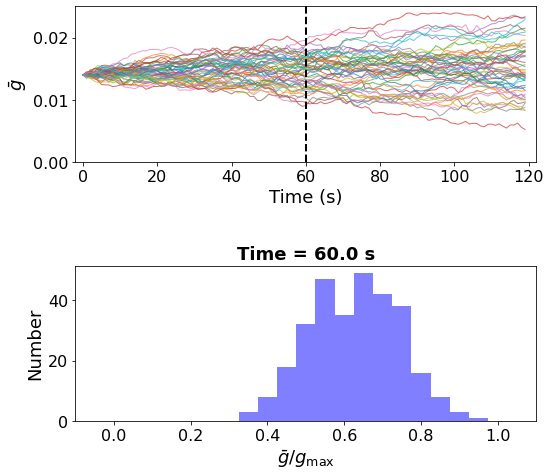

In [14]:
# Example of a LIF model with STDP
example_LIF_STDP(inputrate=15)

### Task 1
Increase the firing rate (i.e., 30 Hz) of pre-synaptic neurons, and investigate the effect on the dynamics of synaptic weight ditribution.

### Effect of input correlations

Thus far, we assumed that the input population was uncorrelated. What do you think will happen if pre-synaptic neurons were correlated? 

In the following, we will modify the input such that first $C$ neurons have identical spike trains while the remaining inputs are uncorrelated. This is a highly simplified model of introducing correlations. You can try to code your own model of correlated spike trains. 

In [15]:
#@title Function `example_LIF_STDP_corrInput(inputrate=?, Tsim=120000.)`

def example_LIF_STDP_corrInput(inputrate=20., Tsim=120000.):
    """
    A LIF model equipped with STDP synapses, receiving correlated inputs

    Args:
      intputrate      :  The rate used for generate presynaptic spike trains
      Tsim            :  Total simulation time

    Returns:
      Interactive demo: Visualization of synaptic weights
    """

    pars = default_pars_STDP(T=Tsim,  dt=1.)
    pars['gE_bar']    = 0.024
    pars['VE']        = 0.   #[mV]
    pars['gE_init']   = 0.024*np.random.rand(300)  # initial synaptic conductance
    pars['tau_syn_E'] = 5.   #[ms]

    starttime = time.perf_counter()
    pre_spike_train_ex = Poisson_generator(pars, rate=20, n=300, myseed=2020)
    for i_pre in range(50):
        pre_spike_train_ex[i_pre, :] = pre_spike_train_ex[0, :] # simple way to set input correlated
    v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars, pre_spike_train_ex) # simulate LIF neuron with STDP
    gbar_norm = gE_bar_update/pars['gE_bar'] # calculate the ratio of the synaptic conductance
    endtime = time.perf_counter()
    timecost = (endtime - starttime)/60.

    print ('Total simulation time is %.3f min' % timecost)

    my_layout.width = '620px'
    @widgets.interact(
        sample_time = widgets.FloatSlider(0.5, min=0., max=1., step=0.1, layout=my_layout)
    )

    def my_visual_STDP_distribution(sample_time=0.0):
        
        sample_time = int(sample_time * pars['range_t'].size) - 1
        sample_time = sample_time*(sample_time>0)
        figtemp = plt.figure(figsize=(8, 8))
        ax1 = figtemp.add_axes([0.15, 0.55, 0.8, 0.27])
        for i in range(50):
            ax1.plot(pars['range_t'][::1000]/1000., gE_bar_update[i, ::1000], lw=1., color='r', alpha=0.7, zorder=2)
        
        for i in range(50):
            ax1.plot(pars['range_t'][::1000]/1000., gE_bar_update[i+50, ::1000], lw=1., color='b', alpha=0.5, zorder=1)

        ax1.axvline(1e-3*pars['range_t'][sample_time], 0., 1., color='k', ls='--', zorder=2)
        ax1.set_ylim(0, 0.025)
        ax1.set_xlim(-2, 122)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel(r'$\bar{g}$')
        legend=ax1.legend(['Correlated input', 'Uncorrelated iput'], fontsize=18,
                          loc=[0.92, -0.6], frameon=False)
        for color, text, item in zip(['r', 'b'], legend.get_texts(), legend.legendHandles):
            text.set_color(color)
            item.set_visible(False)

        bins = np.arange(-.05,1.05,.05)
        g_dis_cc, _ = np.histogram(gbar_norm[:50, sample_time], bins)
        g_dis_dp, _ = np.histogram(gbar_norm[50:, sample_time], bins)
        ax2 = figtemp.add_axes([0.15, 0.1, 0.8, 0.27])
        ax2.bar(bins[1:], g_dis_cc, color='r', alpha=0.5, width=0.05)
        ax2.bar(bins[1:], g_dis_dp, color='b', alpha=0.5, width=0.05)
        ax2.set_xlim(-0.1, 1.1)
        ax2.set_xlabel(r'$\bar{g}/g_{\mathrm{max}}$')
        ax2.set_ylabel('Number')
        ax2.set_title(('Time = %.1f s'%(1e-3*pars['range_t'][sample_time])), 
                  fontweight='bold') 
        plt.show()

print(help(example_LIF_STDP_corrInput))

Help on function example_LIF_STDP_corrInput in module __main__:

example_LIF_STDP_corrInput(inputrate=20.0, Tsim=120000.0)
    A LIF model equipped with STDP synapses, receiving correlated inputs
    
    Args:
      intputrate      :  The rate used for generate presynaptic spike trains
      Tsim            :  Total simulation time
    
    Returns:
      Interactive demo: Visualization of synaptic weights

None


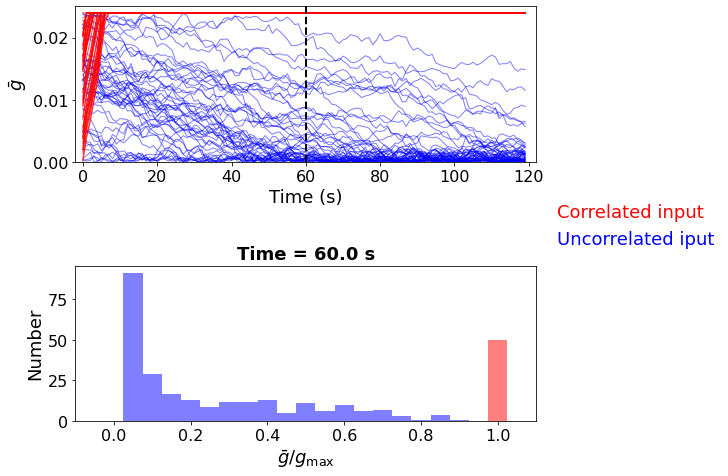

In [16]:
# Example of a LIF model with plastic synapses receiving correlated inputs
example_LIF_STDP_corrInput(inputrate=20.0)

### Why do weights of uncorrelated neurons decrease when synapses show STDP
In the above, we notice that the synapses of corrleate neurons (which spike together) were almost unaffected but the weights of other neurons diminished. Why does this happen? 

The reason is that the correlated pre-synaptic neurons have a higher chance of eliciting a spike in the post-synaptic neurons and that create a $pre \rightarrow post$ pairing of spikes. 

### Task 2
Modify the code above and create two groups of correlated pre-synaptic neurons and test what happens to the weight distribution.

### Think!

* How can the above observations be used to create unsupervised learning? Could you imagine how we have to train a neuronal model enabled with STDP rule to identify input patterns?

* What else can be done with this type of plasticity?


## Summary

Hooray! You have just finished this loooong day! In this tutorial he covered the concept of **spike-timing dependent plasticity (STDP)**.

We managed to:

- build a model of synapse that show STDP.

- study how correlations in input spike trains influence the distribution of synapstic weights.

Using presynaptic inputs as Poisson type spike trains, we modeled an LIF model with synapses equipped with STDP. We studied also the effect of correlated inputs on the synaptic strength!